# Purpose:
- Check out feature encoding.
    - It maybe not good due to being L2. (I might need L1 regularization)
- To remove in feature comparison between sessions.

In [1]:
import numpy as np
import pandas as pd
from importlib import reload
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')
import utils.clustering_index as ci
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import utils.lda_angle_discrim as lda_angle
from sklearn.linear_model import LogisticRegression
import xarray as xr

base_dir = Path(r'E:\TPM\JK\h5')
results_dir = base_dir / 'results'
wf_dir = results_dir / 'touch_whisker_features'
pr_dir = results_dir / 'pop_responses' / 'touch_before_answer'

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]
use_volume_df = use_mice_df.query('plane in [1, 5]')
use_volume_df.loc[:, 'volume'] = use_volume_df['plane'].apply(lambda x: 1 if x==1 else 2)
training_volume_df = use_volume_df.query('session_type == "training"')
remove_ind = training_volume_df.query('mouse==27 and session=="15"')
training_volume_df = training_volume_df.drop(remove_ind.index)
remove_ind = training_volume_df.query('mouse==36 and session=="9"')
training_volume_df = training_volume_df.drop(remove_ind.index)

mice = [25,27,30,36,39,52]
test_sessions = [[4,19], [3,8], [3,21], [1,17], [1,23], [3,21]]
naive_sessions = [10, 4, 11, 6, 6, 11]

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [2]:
mouse = 25
plane = 1
session = 1
roi_dir = base_dir / f'{mouse:03}/plane_{plane}/{session:03}/plane0/roi'
whisker_glm_dir = roi_dir / 'glm/whisker_combined'
# load netcdf file
whisker_glm = xr.open_dataset(whisker_glm_dir / 'glm_result.nc')


In [3]:
whisker_glm.varexp_drop

<xarray.DataArray 'varexp_drop' (cell_id: 120, dropped_feature: 5)>
[600 values with dtype=float64]
Coordinates:
  * cell_id          (cell_id) int32 0 1 2 4 5 7 8 ... 140 141 142 143 144 145
  * dropped_feature  (dropped_feature) object 'whisker_feature' ... 'reward'

In [5]:
whisker_glm.varexp_model_final.values

array([0.03603042, 0.3979267 , 0.34639335, 0.04887651, 0.00902243,
       0.07534858, 0.00347144, 0.00338135, 0.10052021, 0.00334151,
       0.00327452, 0.05203734, 0.12481883, 0.00284852, 0.01054883,
       0.0980952 , 0.0447239 , 0.01115591, 0.05166405, 0.01402051,
       0.0063056 , 0.02540324, 0.0072298 , 0.0024997 , 0.03982091,
       0.01369041, 0.05479764, 0.00081461, 0.04804773, 0.10412596,
       0.08391254, 0.02232711, 0.00703106, 0.13401343, 0.00910525,
       0.01458694, 0.25463593, 0.01351667, 0.0013725 , 0.02083152,
       0.03933387, 0.10399515, 0.03699537, 0.00199766, 0.07530583,
       0.04127719, 0.10414479, 0.09882619, 0.00105682, 0.05147513,
       0.02097493, 0.03900632, 0.00659062, 0.00310105, 0.05103954,
       0.02799577, 0.0030744 , 0.05264167, 0.0282653 , 0.09074096,
       0.02966588, 0.0539049 , 0.01083905, 0.04011384, 0.22122009,
       0.01065267, 0.20303161, 0.05945638, 0.00265786, 0.03039862,
       0.00591842, 0.03641287, 0.0153438 , 0.03708875, 0.00253

# Make files for each feature drop
- without retraining

In [7]:
glm_split = np.load(whisker_glm_dir / 'glm_split.npy', allow_pickle=True).item()

In [6]:
whisker_glm.X

<xarray.DataArray 'X' (index: 4106, feature: 88)>
[361328 values with dtype=float64]
Coordinates:
  * index    (index) int32 0 1 2 3 4 5 6 ... 4099 4100 4101 4102 4103 4104 4105
  * feature  (feature) object 'intercept' ... 'first_reward_lick_right_4'

In [8]:
whisker_glm.X.feature

<xarray.DataArray 'feature' (feature: 88)>
array(['intercept', 'theta_onset_0', 'theta_onset_1', 'theta_onset_2',
       'phi_onset_0', 'phi_onset_1', 'phi_onset_2', 'kappaH_onset_0',
       'kappaH_onset_1', 'kappaH_onset_2', 'kappaV_onset_0', 'kappaV_onset_1',
       'kappaV_onset_2', 'arc_length_onset_0', 'arc_length_onset_1',
       'arc_length_onset_2', 'touch_count_0', 'touch_count_1', 'touch_count_2',
       'delta_theta_0', 'delta_theta_1', 'delta_theta_2', 'delta_phi_0',
       'delta_phi_1', 'delta_phi_2', 'delta_kappaH_0', 'delta_kappaH_1',
       'delta_kappaH_2', 'delta_kappaV_0', 'delta_kappaV_1', 'delta_kappaV_2',
       'touch_duration_0', 'touch_duration_1', 'touch_duration_2',
       'slide_distance_0', 'slide_distance_1', 'slide_distance_2',
       'num_whisks_-2', 'num_whisks_-1', 'num_whisks_0', 'num_whisks_1',
       'num_whisks_2', 'num_whisks_3', 'num_whisks_4', 'midpoint_-2',
       'midpoint_-1', 'midpoint_0', 'midpoint_1', 'midpoint_2', 'midpoint_3',
       'midpoint_4', 'amplitude_-2', 'amplitude_-1', 'amplitude_0',
       'amplitude_1', 'amplitude_2', 'amplitude_3', 'amplitude_4',
       'num_lick_left_-2', 'num_lick_left_-1', 'num_lick_left_0',
       'num_lick_left_1', 'num_lick_left_2', 'num_lick_right_-2',
       'num_lick_right_-1', 'num_lick_right_0', 'num_lick_right_1',
       'num_lick_right_2', 'pole_in_frame_0', 'pole_in_frame_1',
       'pole_in_frame_2', 'pole_in_frame_3', 'pole_in_frame_4',
       'pole_out_frame_0', 'pole_out_frame_1', 'pole_out_frame_2',
       'pole_out_frame_3', 'pole_out_frame_4', 'first_reward_lick_left_0',
       'first_reward_lick_left_1', 'first_reward_lick_left_2',
       'first_reward_lick_left_3', 'first_reward_lick_left_4',
       'first_reward_lick_right_0', 'first_reward_lick_right_1',
       'first_reward_lick_right_2', 'first_reward_lick_right_3',
       'first_reward_lick_right_4'], dtype=object)
Coordinates:
  * feature  (feature) object 'intercept' ... 'first_reward_lick_right_4'

In [9]:
whisker_feature_names_base = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
        'arc_length_onset', 'touch_count', 'delta_theta', 'delta_phi',
        'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']


In [15]:
whisker_feature_dict = {key: [value for value in whisker_glm.X.feature.values if key in value] for key in whisker_feature_names_base}


In [16]:
from scripts import fit_glm_whisker_combined as glm_whisker
varexp_drop, predicted_drop, W_drop, lambdas_drop = \
    glm_whisker.drop_feature_and_fit(whisker_glm.X, whisker_glm.traces, 
                                     glm_split['lambda_groups'], glm_split['fit_groups'],
                                     whisker_feature_dict)

In [20]:
varexp = whisker_glm.varexp_model_final
unique_contribution = (varexp - varexp_drop) / varexp

C:\Users\shires\AppData\Local\Temp/ipykernel_408/1524690186.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_importance.dropped_feature.values, rotation=45, ha='right');


Text(0.5, 1.0, 'JK025 plane 1 session 001\nAll cells')

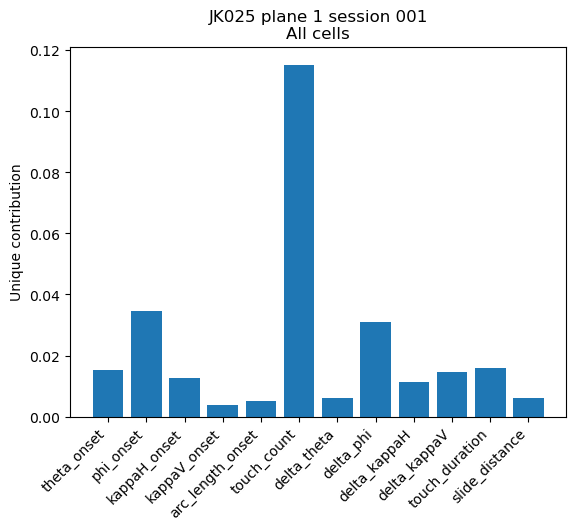

In [80]:
fig, ax = plt.subplots()
ax.bar(unique_contribution.dropped_feature.values, unique_contribution.mean(dim='cell_id').values)
ax.set_xticklabels(unique_contribution.dropped_feature.values, rotation=45, ha='right');
ax.set_ylabel('Unique contribution')
ax.set_title(f'JK{mouse:03} plane {plane} session {session:03}\nAll cells')

C:\Users\shires\AppData\Local\Temp/ipykernel_408/1379475532.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_importance.dropped_feature.values, rotation=45, ha='right');


Text(0.5, 1.0, 'JK025 plane 1 session 001\nFrom fit cells')

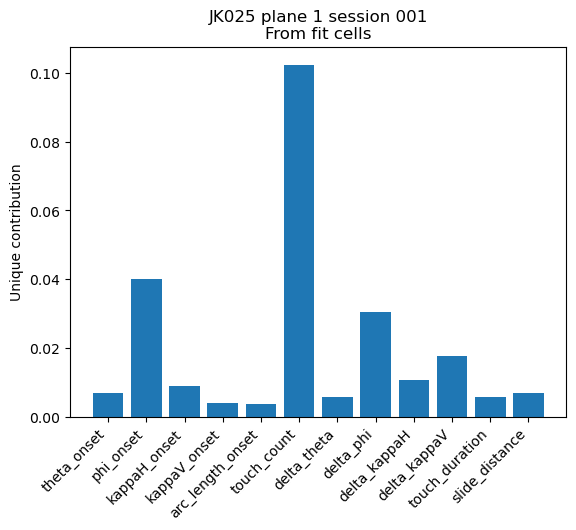

In [81]:
fit_cell_ind = np.where(varexp > 0.05)[0]
fig, ax = plt.subplots()
ax.bar(unique_contribution.dropped_feature.values, unique_contribution.isel(cell_id=fit_cell_ind).mean(dim='cell_id').values)
ax.set_xticklabels(unique_contribution.dropped_feature.values, rotation=45, ha='right');
ax.set_ylabel('Unique contribution')
ax.set_title(f'JK{mouse:03} plane {plane} session {session:03}\nFrom fit cells')

## Look at feature importance without retraining

In [69]:
whisker_feature_names_base = ['theta_onset', 'phi_onset', 'kappaH_onset', 'kappaV_onset',
        'arc_length_onset', 'touch_count', 'delta_theta', 'delta_phi',
        'delta_kappaH', 'delta_kappaV', 'touch_duration', 'slide_distance']
whisker_feature_dict = {key: [value for value in whisker_glm.X.feature.values if key in value] for key in whisker_feature_names_base}

ve_drop = []
for key, value in whisker_feature_dict.items():
    X_temp = whisker_glm.X.copy()
    X_temp.loc[{'feature': value}] = 0
    _, ve = glm_whisker.variance_ratio(whisker_glm.traces, whisker_glm.W_final, X_temp)
    ve_drop.append(ve)


In [77]:
ve_drop = xr.DataArray(np.array(ve_drop), dims=('feature', 'cell_id'), 
                       coords={'cell_id': whisker_glm.traces.cell_id.values,
                               'feature': list(whisker_feature_dict.keys())})


C:\Users\shires\AppData\Local\Temp/ipykernel_408/213814839.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_importance.feature.values, rotation=45, ha='right');


Text(0.5, 1.0, 'JK025 plane 1 session 001\nAll cells')

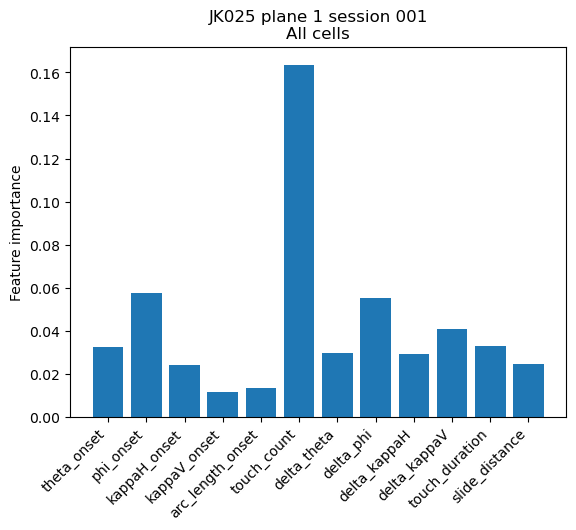

In [83]:
varexp = whisker_glm.varexp_model_final
feature_importance = (varexp - ve_drop) / varexp
fig, ax = plt.subplots()
ax.bar(feature_importance.feature.values, feature_importance.mean(dim='cell_id').values)
ax.set_xticklabels(feature_importance.feature.values, rotation=45, ha='right');
ax.set_ylabel('Feature importance')
ax.set_title(f'JK{mouse:03} plane {plane} session {session:03}\nAll cells')

C:\Users\shires\AppData\Local\Temp/ipykernel_408/2419009489.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_importance.feature.values, rotation=45, ha='right');


Text(0.5, 1.0, 'JK025 plane 1 session 001\nFrom fit cells')

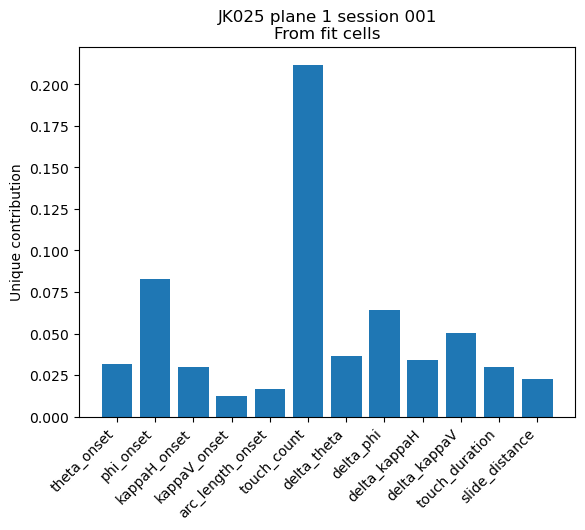

In [85]:
fit_cell_ind = np.where(varexp > 0.05)[0]
fig, ax = plt.subplots()
ax.bar(feature_importance.feature.values, feature_importance.isel(cell_id=fit_cell_ind).mean(dim='cell_id').values)
ax.set_xticklabels(feature_importance.feature.values, rotation=45, ha='right');
ax.set_ylabel('Unique contribution')
ax.set_title(f'JK{mouse:03} plane {plane} session {session:03}\nFrom fit cells')

# Run unique contribution and feature importance in parallel